In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob

from helper_funcs import load_energy_data, load_temperature, merge_datasets, resample_as_needed

#from gluonts.model import deepar
from gluonts.mx.trainer import Trainer
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.model.deepar import DeepAREstimator
from gluonts.dataset.common import ListDataset
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator
from gluonts.model.n_beats import NBEATSEnsembleEstimator

from itertools import islice
#!!!!#
# !pip install --upgrade mxnet==1.6
# !pip install gluonts
#In case you get troubles with the mxnet installation, check if the numpy version satisfies the requirement and potentially downgrade


DeepAREstimator, which implements the DeepAR model proposed in the DeepAR: Probabilistic Forecasting with Autoregressive Recurrent Networks paper - https://arxiv.org/abs/1704.04110. Given one or more time series, the model is trained to predict the next prediction_length values given the preceding context_length values. 

Instead of predicting single best values for each position in the prediction range, the model parametrizes a parametric probability distribution for each output position.

For collection of GluonTS examples, head here: https://github.com/awslabs/gluon-ts/tree/master/examples

https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html

The training input for the DeepAR algorithm is one or, preferably, more target time series that have been generated by the same process or similar processes. Based on this input dataset, the algorithm trains a model that learns an approximation of this process/processes and uses it to predict how the target time series evolves. Each target time series can be optionally associated with a vector of static (time-independent) categorical features provided by the cat field and a vector of dynamic (time-dependent) time series provided by the dynamic_feat field. 

From the docs:

We recommend training a DeepAR model on as many time series as are available. Although a DeepAR model trained on a single time series might work well, standard forecasting algorithms, such as ARIMA or ETS, might provide more accurate results. The DeepAR algorithm starts to outperform the standard methods when your dataset contains hundreds of related time series. Currently, DeepAR requires that the total number of observations available across all training time series is at least 300.


In [2]:
# Data Load
energy = load_energy_data("../data/") # Load the energy consumption data
temp = load_temperature('../data/avg_temp.csv') # Load the temperature data
final_df = merge_datasets(energy, temp)
print(final_df.info())
print(final_df.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52614 entries, 0 to 52613
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   time      52614 non-null  datetime64[ns]
 1   actuals   52546 non-null  float64       
 2   avg_temp  52614 non-null  float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 1.6 MB
None
                 time  actuals  avg_temp
0 2015-01-01 00:00:00   5024.0      -9.7
1 2015-01-01 01:00:00   4773.0      -9.7
2 2015-01-01 02:00:00   4585.0      -9.7
3 2015-01-01 03:00:00   4440.0      -9.7
4 2015-01-01 04:00:00   4418.0      -9.7


In [3]:
data = final_df.pipe(resample_as_needed)
CUTOFF = pd.to_datetime('2019-12-31')

#Start time is the beginning of the time s
training_data = ListDataset(
    [{"start": data.index.min(), "target": data.actuals.loc[:CUTOFF]}],
    freq = "1D"
)



Full documentation - https://ts.gluon.ai/api/gluonts/gluonts.model.deepar.html

Key hyperparameters:
https://docs.aws.amazon.com/sagemaker/latest/dg/deepar_hyperparameters.html

context_length - The number of time-points that the model gets to see before making the prediction. The value for this parameter should be about the same as the prediction_length. The model also receives lagged inputs from the target, so context_length can be much smaller than typical seasonalities. For example, a daily time series can have yearly seasonality. The model automatically includes a lag of one year, so the context length can be shorter than a year. The lag values that the model picks depend on the frequency of the time series. For example, lag values for daily frequency are previous week, 2 weeks, 3 weeks, 4 weeks, and year.

..

early_stopping_patience - default is 10

In [4]:
estimator = DeepAREstimator(
    prediction_length=365,
    context_length=180, #Default is equal to the prediction length
    freq='1D',
    num_layers=2,
    num_cells=128,
    cell_type='lstm',
    trainer=Trainer(ctx="cpu",
                    epochs=5,
                    learning_rate=1e-3,
                    num_batches_per_epoch=100)
    )

predictor = estimator.train(training_data)

Multiprocessing is not supported on Windows, num_workers will be set to None.
  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|████████████████████████████████████████████████| 100/100 [03:40<00:00,  2.21s/it, epoch=5/5, avg_epoch_loss=6.93]


In [5]:
# Provide as many splits as necessary/interesting.
test_data = ListDataset(
    [
     {"start": data.index.min(), "target": data.actuals}, 
     {"start": data.index.min(), "target": data.actuals.loc[:'2020-04-01']},
     ],
    freq = "1D"
)

In [6]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_data,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

forecast_it

<generator object GluonPredictor.predict at 0x0000017A1F771350>

In [7]:
forecasts = list(forecast_it)
tss = list(ts_it)
forecasts

[gluonts.model.forecast.SampleForecast(freq="1D", info=None, item_id=None, samples=numpy.array([[4166.57177734375, 3678.597900390625, 2779.703857421875, 2925.656982421875, 3958.441650390625, 3639.06005859375, 4033.825927734375, 3280.915283203125, 4104.2763671875, 4500.21923828125, 4599.46435546875, 4560.19677734375, 4945.2734375, 5078.6982421875, 5419.0927734375, 5222.18994140625, 4557.095703125, 4867.88623046875, 5084.56103515625, 5857.154296875, 5577.583984375, 5493.72998046875, 5480.71337890625, 5235.50634765625, 5059.7548828125, 5411.38818359375, 5201.30517578125, 4955.943359375, 4927.09716796875, 4679.40576171875, 5176.90478515625, 4427.208984375, 4249.60107421875, 3771.6533203125, 3363.725341796875, 3793.3671875, 3788.608642578125, 3797.2021484375, 3704.1787109375, 3805.156494140625, 4526.31591796875, 4592.28125, 4779.8232421875, 5315.77880859375, 4773.1953125, 4589.98388671875, 4856.14111328125, 4850.13037109375, 4825.8544921875, 5026.314453125, 4828.42041015625, 4293.3852539062

In [8]:
# first entry of the time series list
ts_entry = tss[0]

# first entry of dataset.test
dataset_test_entry = next(iter(test_data))

# first entry of the forecast list
forecast_entry = forecasts[0]

print(f"Number of sample paths: {forecast_entry.num_samples}")
print(f"Dimension of samples: {forecast_entry.samples.shape}")
print(f"Start date of the forecast window: {forecast_entry.start_date}")
print(f"Frequency of the time series: {forecast_entry.freq}")

Number of sample paths: 100
Dimension of samples: (100, 365)
Start date of the forecast window: 2020-01-02 00:00:00
Frequency of the time series: 1D


In [9]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 150
    prediction_intervals = (75.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

In [10]:
def plot_forecasts(tss, forecasts, past_length, num_plots):
    for target, forecast in islice(zip(tss, forecasts), num_plots):
        ax = target[-past_length:].plot(figsize=(12, 5), linewidth=2)
        forecast.plot(color='g')
        plt.grid(which='both')
        plt.legend(["observations", "median prediction", "90% confidence interval", "50% confidence interval"])
        plt.show()

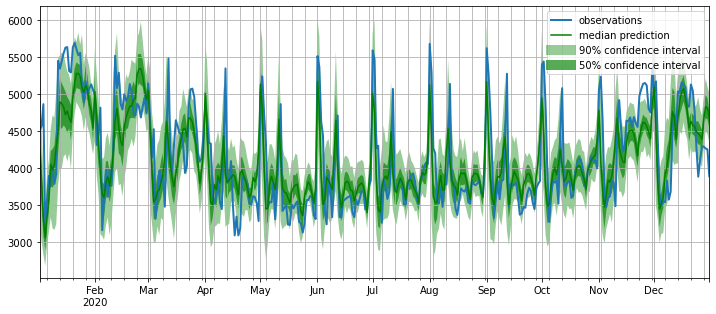

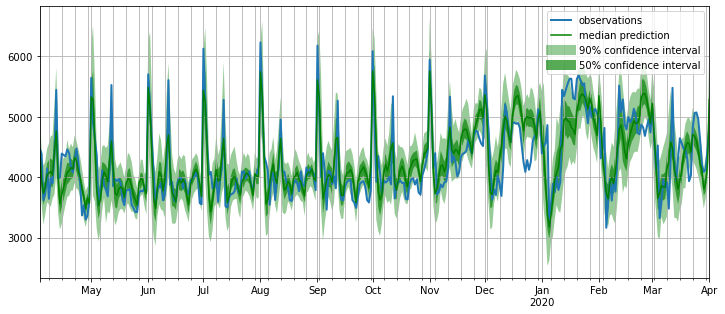

In [11]:
plot_forecasts(tss, forecasts, past_length=365, num_plots=2)

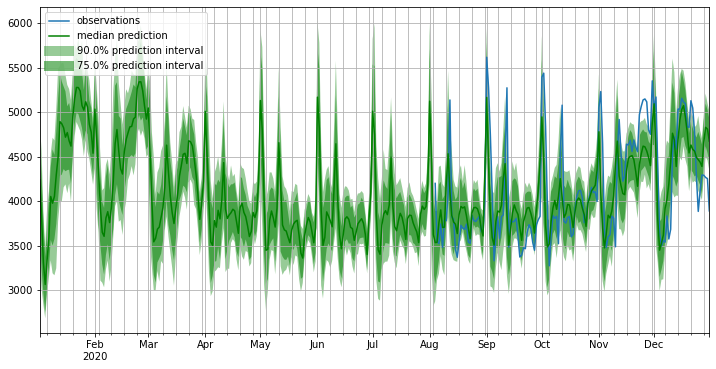

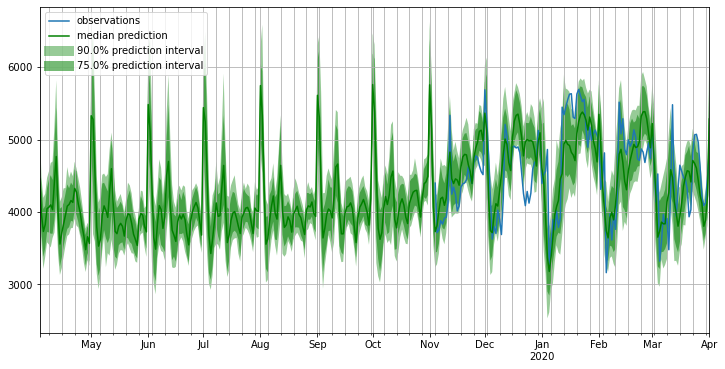

In [12]:
plot_prob_forecasts(tss[0], forecasts[0])
plot_prob_forecasts(tss[1], forecasts[1])

In [13]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_data))

item_metrics

Running evaluation: 100%|███████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 295.29it/s]


,item_id,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,OWA,MSIS,QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9]
0,NaN,172162.104110,113183.742188,1516636.50,4155.168493,318.801752,0.972681,0.072515,0.073493,NaN,6.427977,46324.502979,0.131507,113183.743164,0.542466,61668.805664,0.813699
1,NaN,121201.128767,98010.859375,1555537.25,4261.745890,315.077481,0.852244,0.061985,0.061902,NaN,5.407079,42231.539355,0.139726,98010.854980,0.578082,46079.523926,0.884932


## Multiple time series forecasting

In [14]:
for i in range(7):
    data[f"actuals{i}"] = data.actuals*np.random.uniform(0.80, 1.2, size=len(data.actuals))

In [15]:
data

,actuals,avg_temp,actuals0,actuals1,actuals2,actuals3,actuals4,actuals5,actuals6
time,,,,,,,,,
2015-01-01,4994.333333,-9.7,4979.265751,4267.818061,4230.777651,4526.095913,4271.014819,4369.455106,4001.818628
2015-01-02,4642.083333,-6.2,4375.209330,5045.449220,5289.551463,4500.554905,4518.123512,4189.269663,3726.340033
2015-01-03,4203.875000,0.2,3799.315790,4578.071530,3797.777969,3938.313268,3386.355328,4760.522953,4381.114787
2015-01-04,4436.208333,0.2,4114.895720,4536.381843,4883.205544,3909.436929,4065.037486,4714.259530,4074.119747
2015-01-05,3497.166667,-1.7,4104.685778,4172.672670,4146.020805,3651.788370,2984.922246,3112.247874,2834.530622
...,...,...,...,...,...,...,...,...,...
2020-12-27,4293.416667,4.8,4578.093494,4733.161834,3436.188726,3543.844365,4801.378223,4146.541039,4800.073009
2020-12-28,4290.041667,9.0,4141.721248,4286.056074,4767.102470,4821.407332,4268.430079,4153.427234,4391.331268
2020-12-29,4265.083333,11.6,4845.257219,4366.753846,3689.801736,4555.405831,4179.391585,4612.009080,4304.485433


In [16]:
data[[col for col in data.columns if 'actuals' in col]]

,actuals,actuals0,actuals1,actuals2,actuals3,actuals4,actuals5,actuals6
time,,,,,,,,
2015-01-01,4994.333333,4979.265751,4267.818061,4230.777651,4526.095913,4271.014819,4369.455106,4001.818628
2015-01-02,4642.083333,4375.209330,5045.449220,5289.551463,4500.554905,4518.123512,4189.269663,3726.340033
2015-01-03,4203.875000,3799.315790,4578.071530,3797.777969,3938.313268,3386.355328,4760.522953,4381.114787
2015-01-04,4436.208333,4114.895720,4536.381843,4883.205544,3909.436929,4065.037486,4714.259530,4074.119747
2015-01-05,3497.166667,4104.685778,4172.672670,4146.020805,3651.788370,2984.922246,3112.247874,2834.530622
...,...,...,...,...,...,...,...,...
2020-12-27,4293.416667,4578.093494,4733.161834,3436.188726,3543.844365,4801.378223,4146.541039,4800.073009
2020-12-28,4290.041667,4141.721248,4286.056074,4767.102470,4821.407332,4268.430079,4153.427234,4391.331268
2020-12-29,4265.083333,4845.257219,4366.753846,3689.801736,4555.405831,4179.391585,4612.009080,4304.485433


array([<AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>],
      dtype=object)

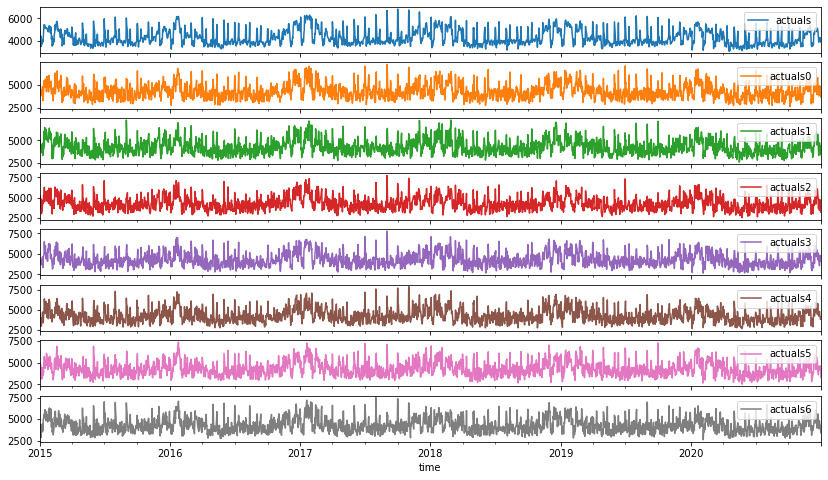

In [17]:
data[[col for col in data.columns if 'actuals' in col]].plot(subplots=True, figsize=(14,8))

array([<AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>],
      dtype=object)

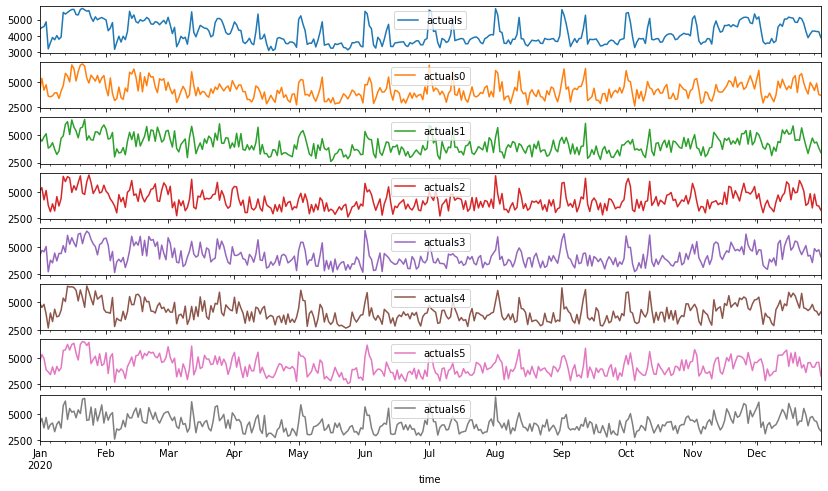

In [18]:
data.loc['2020-01-01':, [col for col in data.columns if 'actuals' in col]].plot(subplots=True, figsize=(14,8))

In [19]:
from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName

train_data = ListDataset([
    {
        FieldName.TARGET: data[target].values,
        FieldName.START: data.index.min(),
    }
    for target in data[[col for col in data.columns if 'actuals' in col]]
], freq='D')

In [20]:
estimator = DeepAREstimator(
    prediction_length=365,
    context_length=180, #Default is equal to the prediction length
    freq='1D',
    num_layers=2,
    num_cells=128,
    cell_type='lstm',
    trainer=Trainer(ctx="cpu",
                    epochs=5,
                    learning_rate=1e-3,
                    num_batches_per_epoch=100)
    )

predictor = estimator.train(training_data)

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|████████████████████████████████████████████████| 100/100 [04:47<00:00,  2.87s/it, epoch=5/5, avg_epoch_loss=6.87]


In [24]:
additional_countries = pd.read_csv("../data/load_countries.csv", index_col=0)
additional_countries = additional_countries.fillna(additional_countries.median())
additional_countries.index = pd.to_datetime(additional_countries.index)

In [33]:
all_countries = additional_countries.merge(data.actuals, 
                                           left_index=True,
                                           right_index=True,
                                           how='left'
                          )
all_countries = all_countries.rename({'actuals':'BG'}, axis=1)

In [125]:
train_data = ListDataset([
    {
        FieldName.TARGET: all_countries.loc[:'2020-01-01', target].values,
        FieldName.START: all_countries.loc[:'2020-01-01', target].index.min(),
    }
    for target in all_countries.loc[:'2020-01-01']], 
    freq='D')

In [126]:
estimator = DeepAREstimator(
    prediction_length=365,
    context_length=180, #Default is equal to the prediction length
    freq='1D',
    num_layers=2,
    num_cells=128,
    cell_type='lstm',
    trainer=Trainer(ctx="cpu",
                    epochs=5,
                    learning_rate=1e-3,
                    num_batches_per_epoch=100)
    )

predictor = estimator.train(training_data)

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|████████████████████████████████████████████████| 100/100 [03:58<00:00,  2.38s/it, epoch=5/5, avg_epoch_loss=6.94]


In [127]:
# Provide as many splits as necessary/interesting.
test_data = ListDataset(
    [
     {"start": data.index.min(), "target": data.actuals}, 
     {"start": data.index.min(), "target": data.actuals.loc['2020-01-01':]},
     ],
    freq = "1D"
)

In [134]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_data,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

forecast_it

<generator object GluonPredictor.predict at 0x0000017A222252E0>

In [129]:
forecasts = list(forecast_it)
tss = list(ts_it)

In [135]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(ts_it), iter(forecast_it), num_series=len(test_data))

item_metrics

Running evaluation: 100%|████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.65s/it]


,item_id,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,OWA,MSIS,QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9]
0,NaN,591484.493151,248479.984375,1516636.5,4155.168493,318.801752,2.135393,0.159042,0.175731,NaN,15.246123,86905.886230,0.000000,248479.987305,0.030137,164713.798877,0.326027
1,NaN,321105.293151,157312.562500,1516636.5,4155.168493,NaN,NaN,0.100327,0.102775,NaN,NaN,68099.983057,0.049315,157312.554932,0.375342,81848.023535,0.769863


In [136]:
pd.DataFrame(forecasts[1].samples).T.median(axis=1)

0      3277.527344
1      3197.882812
2      3554.378418
3      3396.006836
4      3595.937500
          ...     
360    4517.460938
361    4615.607910
362    4623.494141
363    4653.988281
364    4810.894531
Length: 365, dtype: float32

In [137]:
delta = data.actuals.loc['2020-01-01':'2020-12-30'].values - pd.DataFrame(forecasts[0].samples).T.median(axis=1)

In [138]:
delta.index = data.actuals.loc['2020-01-01':'2020-12-30'].index

<AxesSubplot:xlabel='time'>

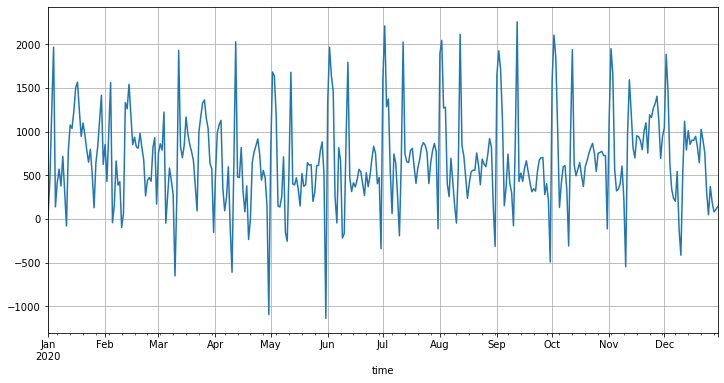

In [139]:
delta.plot(figsize=(12,6), grid=True)

In [140]:
delta.abs().sum()/len(delta)

727.4230580175451

In [141]:
gluon_ts = pd.DataFrame(forecasts[0].samples).T.median(axis=1)
gluon_ts.index = data.actuals.loc['2020-01-01':'2020-12-30'].index

In [101]:
prophet = pd.read_clipboard()

In [107]:
prophet = prophet.set_index('ds')

In [112]:
prophet.index = data.actuals.loc['2020-01-01':'2020-12-30'].index

In [142]:
combo_forecast = pd.concat([data.actuals.loc['2020-01-01':'2020-12-30'], prophet.yhat, gluon_ts], axis=1)
combo_forecast.columns = ['y','prophet', 'gluon_ts']

<AxesSubplot:xlabel='time'>

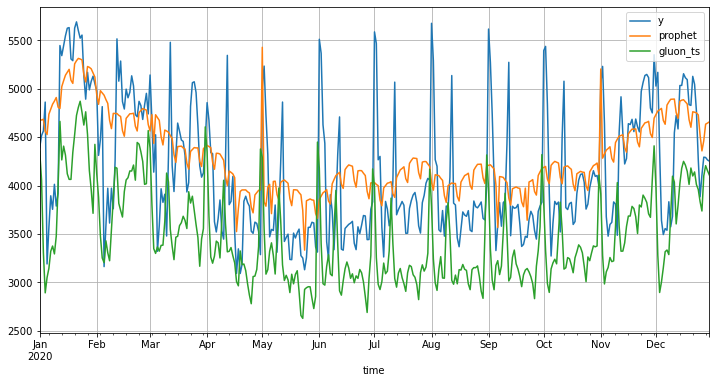

In [143]:
combo_forecast.plot(figsize=(12,6), grid=True)

array([<AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>], dtype=object)

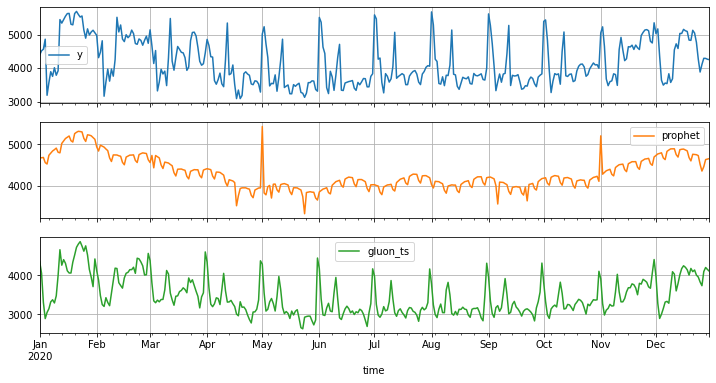

In [144]:
combo_forecast.plot(figsize=(12,6), grid=True, subplots=True)

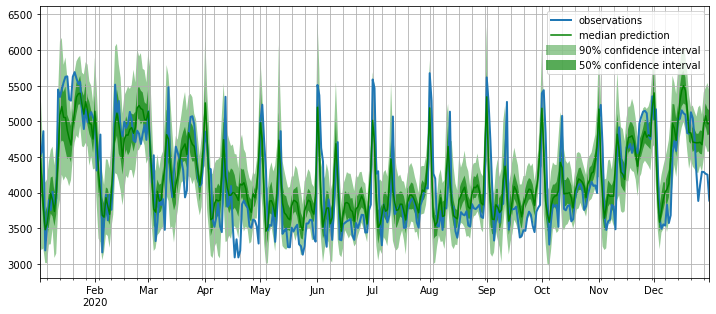

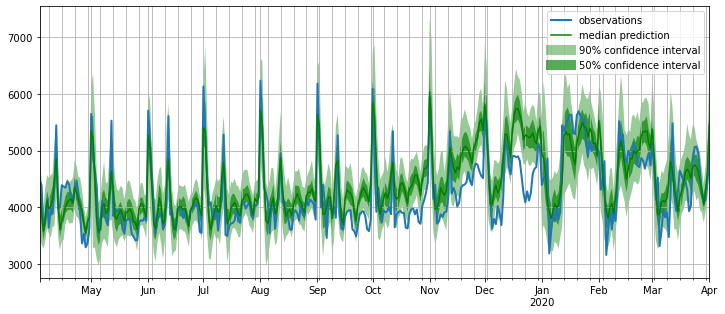

In [60]:
plot_forecasts(tss, forecasts, past_length=365, num_plots=2)